In [1]:
# 步骤
# 1.读取图片
# 2.裁剪出人脸
# 3.转为BLob格式
# 4.处理所有图片
# 5.存储为numpy 文件

In [2]:
# 导入相关包
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 1.读取图片

In [3]:
# 读取图片
img = cv2.imread('./images/1.yes/1.png')

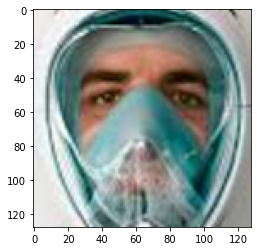

In [4]:
# 显示图片
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

## 2.裁剪人脸

In [5]:
#加载SSD模型
face_detector = cv2.dnn.readNetFromCaffe('./weights/deploy.prototxt.txt','weights/res10_300x300_ssd_iter_140000.caffemodel')

In [6]:
# 转为Blob
img_blob = cv2.dnn.blobFromImage(img,1,(300,300),(104,177,123),swapRB=True)

In [7]:
# 输入
face_detector.setInput(img_blob)

In [8]:
# 推理
detections = face_detector.forward()

In [9]:
detections.shape

(1, 1, 200, 7)

In [10]:
# 人数
person_count = detections.shape[2]

In [11]:
person_count

200

In [12]:
# 人脸检测函数
def face_detect(img):
    #转为Blob
    img_blob = cv2.dnn.blobFromImage(img,1,(300,300),(104,177,123),swapRB=True)
    # 输入
    face_detector.setInput(img_blob)
    # 推理
    detections = face_detector.forward()
    # 获取原图尺寸
    img_h,img_w = img.shape[:2]
    
    # 人脸数量
    person_count = detections.shape[2]

    for face_index in range(person_count):
        # 置信度
        confidence = detections[0,0,face_index,2]
        if confidence > 0.5:
            locations = detections[0,0,face_index,3:7] * np.array([img_w,img_h,img_w,img_h])
            # 取证
            l,t,r,b = locations.astype('int')
            # cv2.rectangle(img,(l,t),(r,b),(0,255,0),5)
            return img[t:b,l:r]
    return None

In [13]:
# 测试图片
img_new = cv2.imread('./images/1.yes/1.png')

In [14]:
face_crop = face_detect(img_new)

In [15]:
face_crop.shape

(122, 103, 3)

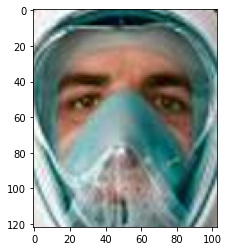

In [16]:
# 显示图片
plt.imshow(cv2.cvtColor(face_crop,cv2.COLOR_BGR2RGB))

## 3.转为Blob图像

In [17]:
# 转为Blob的函数
def imgBlob(img):
    # 转为Blob
    img_blob = cv2.dnn.blobFromImage(img,1,(100,100),(104,177,123),swapRB=True)
    # 压缩维度
    img_squeeze = np.squeeze(img_blob).T
    # 旋转
    img_rotate = cv2.rotate(img_squeeze,cv2.ROTATE_90_CLOCKWISE)
    # 镜像
    img_flip =  cv2.flip(img_rotate,1)
    # 去除负数，并归一化
    img_blob = np.maximum(img_flip,0) / img_flip.max()
    return img_blob

In [18]:
img_test = cv2.imread('./images/1.yes/1.png')

In [19]:
img_blob = imgBlob(img_test)

In [20]:
img_blob.max(),img_blob.min()

(1.0, 0.0)

In [21]:
img_blob.shape

(100, 100, 3)

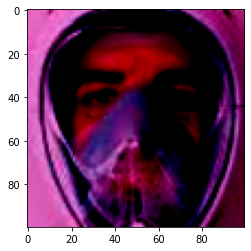

In [22]:
# 显示图片
plt.imshow(img_blob)

## 4.处理所有图片

In [23]:
# 获取图片类别 labels

In [24]:

import os,glob

In [25]:
import tqdm

In [26]:
labels = os.listdir('images/')

In [27]:
# 遍历所有类别

# 两个列表保存结果
img_list = []
label_list = []
for label in labels:
    # 获取每类文件列表
    file_list =glob.glob('images/%s/*.png' % (label))
    
    for img_file in tqdm.tqdm( file_list ,desc = "处理 %s "  % (label)):
        # 读取文件
        img = cv2.imread(img_file)
        # 裁剪人脸
        img_crop = face_detect(img)
        # 判断空的情况
        if img_crop is not None:
            # 转为Blob
            img_blob = imgBlob(img_crop)
            img_list.append(img_blob)
            label_list.append(label)
    

处理 .DS_Store : 0it [00:00, ?it/s]
处理 3.nose :  30%|██▉       | 893/2994 [00:18<00:43, 48.47it/s]D:\work_tools\Anaconda3\envs\tensorflow_workstation\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
处理 3.nose : 100%|██████████| 2994/2994 [01:02<00:00, 47.88it/s]


## 5.保存为numpy文件

In [28]:
# 转为numpy数据
X = np.asarray(img_list)
Y = np.asarray(label_list)

In [29]:
X.shape,Y.shape

((7100, 100, 100, 3), (7100,))

In [30]:
# 存储为numpy文件
np.savez('./data/imageData.npz',X,Y)